<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/10xCRISPR/10xCRISPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Wed Jun 23 22:43:43 UTC 2021


In [2]:
!rm -rf BMGP_2020
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (270/270), done.
remote: Total 600 (delta 112), reused 141 (delta 33), pack-reused 296
Receiving objects: 100% (600/600), 428.83 MiB | 24.06 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Checking out files: 100% (137/137), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 99kB/s 
     |████████████████████████████████| 133kB 15.4MB/s 
     |████████████████████████████████| 10.3MB 33.8MB/s 
     |████████████████████████████████| 19.1MB 98kB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 112kB 37.7MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 1.2MB 30.0MB/s 


In [4]:
# extract everything
!ls /content/BMGP_2020/data/10xCRISPR/kite/*.tar.gz |xargs -n1 tar -xf

In [5]:
!gunzip /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/*

In [6]:
!cat /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/xaa \
/content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/xab > \
/content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/matrix.mtx

In [7]:
!mv /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix ./

In [8]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

Looking in indexes: https://test.pypi.org/simple/


# Imports

In [9]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

colors = {
    "kb": "black",
    "cs": "red"
}

In [10]:
path = "/content/counts_unfiltered/adata.h5ad"

raw_kb = anndata.read_h5ad(path)

In [11]:
mat_path = "/content/raw_feature_bc_matrix/matrix.mtx"
bcs_path = "/content/raw_feature_bc_matrix/barcodes.tsv"
ftr_path = "/content/raw_feature_bc_matrix/features_1_col.tsv"
t2g_path = "/content/BMGP_2020/references/10xCRISPR/kite/f2b.txt"

raw_cr = import_matrix_as_anndata(mat_path, bcs_path, ftr_path, t2g_path=t2g_path)
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16).values

In [12]:
bcs_path = "/content/counts_filtered/cells_x_features.barcodes.txt"
df = pd.read_csv(bcs_path, names=["bcs"], header=None)

In [13]:
common = np.intersect1d(np.intersect1d(raw_cr.obs.index.values, raw_kb.obs.index.values), df.bcs.values)

In [14]:
kb = raw_kb[raw_kb.obs.index.isin(common)]
cr = raw_cr[raw_cr.obs.index.isin(common)]

In [15]:
print(kb)
print(cr)

View of AnnData object with n_obs × n_vars = 3117 × 93
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 3117 × 36694
    var: 'gene_name'


In [16]:
common_genes = np.intersect1d(kb.var.index.values, cr.var.index.values)

In [17]:
kb = kb[:,kb.var.index.isin(common_genes)].copy()
cr = cr[:,cr.var.index.isin(common_genes)].copy()

In [18]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 3117 × 93
    var: 'feature_name'
AnnData object with n_obs × n_vars = 3117 × 93
    var: 'gene_name'


In [19]:
False in kb.obs.index.values == cr.obs.index.values

False

In [20]:
False in kb.var.index.values == cr.var.index.values

False

In [21]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 3117 × 93
    var: 'feature_name'
AnnData object with n_obs × n_vars = 3117 × 93
    var: 'gene_name'


In [22]:
kb.layers[0] = kb.X
kb.layers[1] = cr.X

kb.write_h5ad("10xCRISPR.h5ad")

# Visualizations

In [23]:
labels = ["kb", "cr"]
colors = ["#e41a1c", "#377eb8"]

## Knee

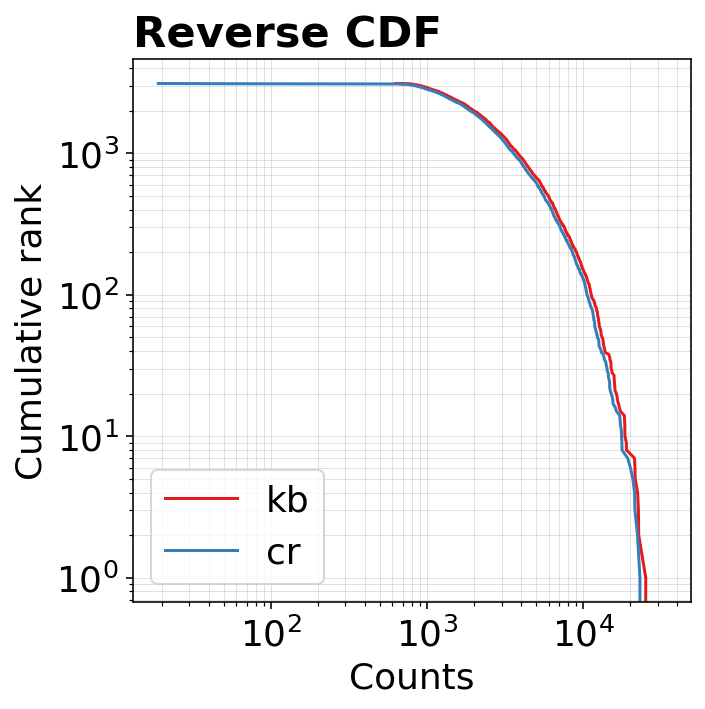

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cr.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)

fig.show()

## pseudobulk

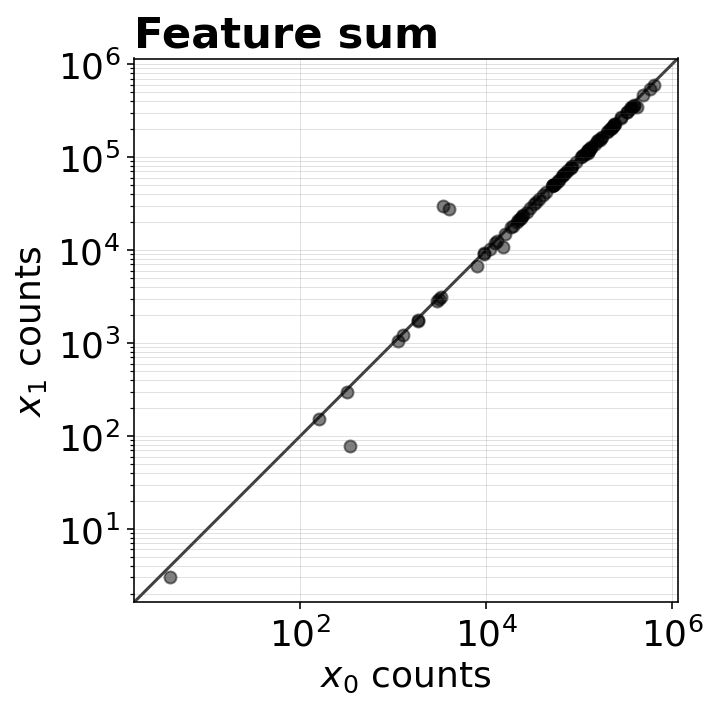

In [33]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

In [37]:
kb.var[(x0-x1).astype(int)<0]

,feature_name
feature_id,
EZR-1,EZR-1
PPIB-2,PPIB-2


In [ ]:
# kmer alignment index
kallisto inspect -G gfa features.idx

S       664     GGGCACTCGGCGGACGCAA     XT:S:EZR-2-1.2

# Single sequence with two alignments
AAGCAGTGGTATCAACGCAGAGTACATG GGGCACTCGGCGGACGCAA GGGGTTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAAT
AAGCAGTGGTATCAACGCAGAGTACATGGGG CACTCGGCGGACGCAAGGG GTTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAAT

# Problem BC 1 (EZR-1)
EZR-1	        CACTCGGCGGACGCAA GGG
EZR-2     GCG CACTCGGCGGACGCAA

# Problem BC 1 (PPIB-2)
PPIB-1   GGA GAGGCGCAGCATCCAC	
PPIB-2       GAGGCGCAGCATCCAC AGG

PPIB-2_rc CCTGTGGATGCTGCGC  

# Protospacer sequence
AAGCAGTGGTATCAACGCAGAGTACATGGGG -(BC)- GTTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAAT

# Pseudobulk - cell

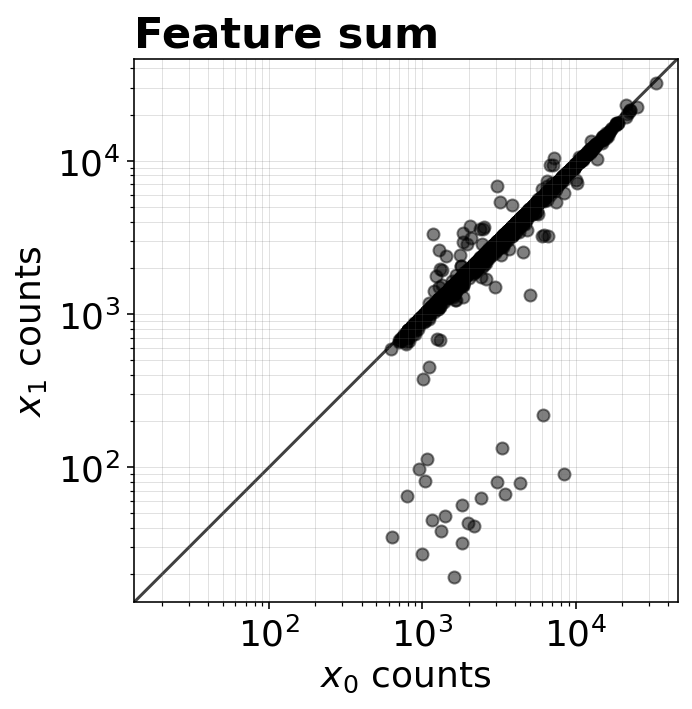

In [26]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X, axis=1)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

# Feature correlation

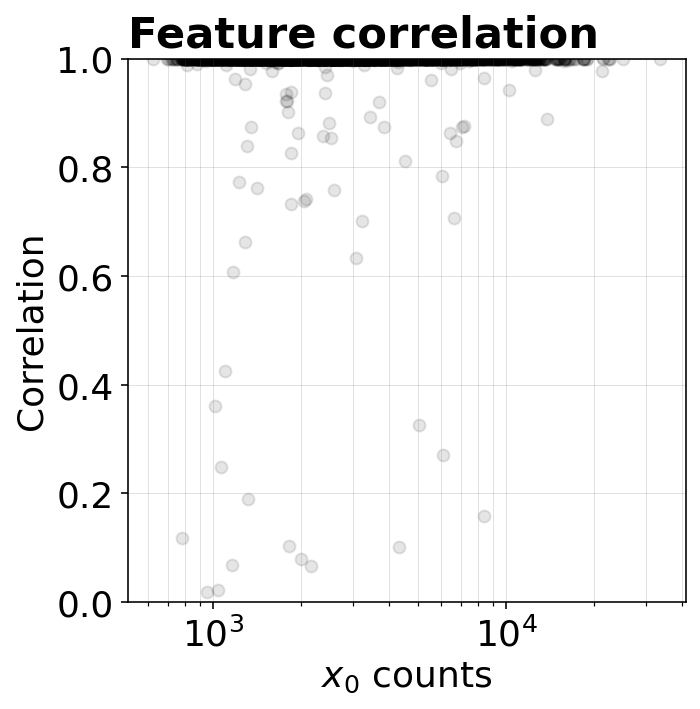

In [27]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cr.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [28]:
# logged counts
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cr.X))
YY_YX = compare.l1_distance(np.log1p(cr.X), np.log1p(kb.X))

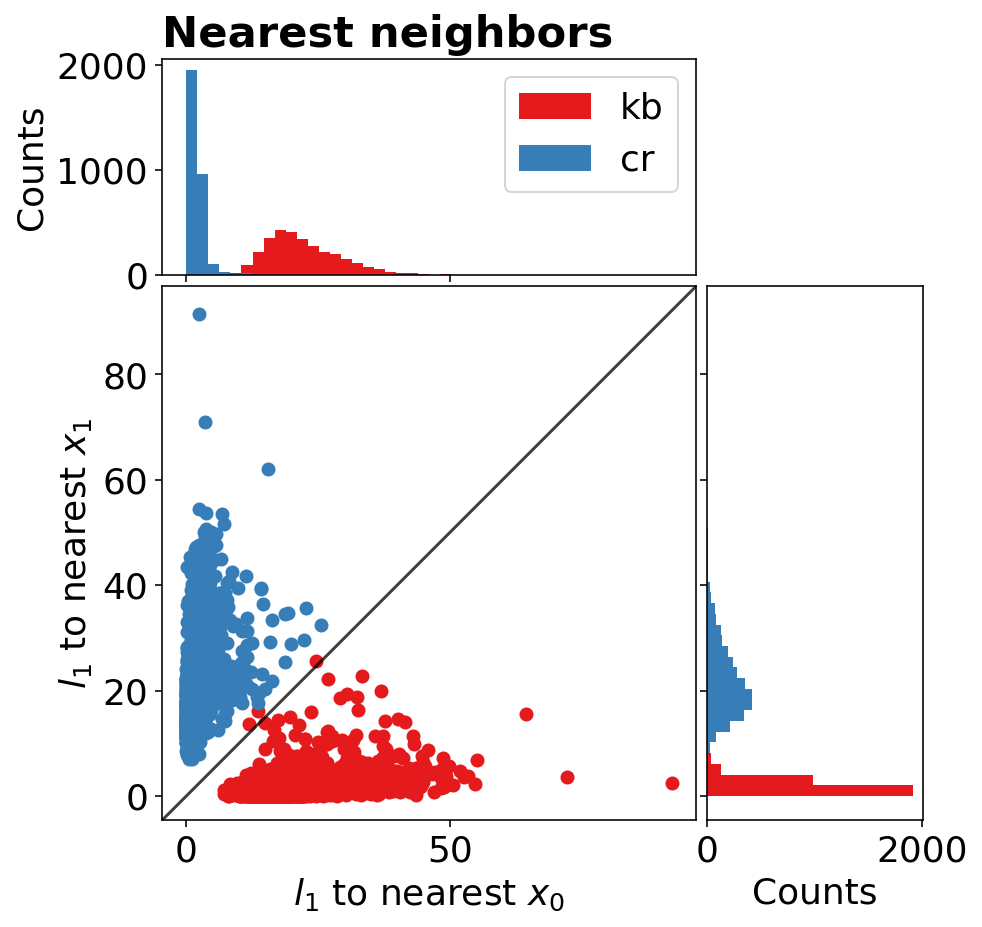

In [29]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [30]:
XX, XY = XX_XY
YY, YX = YY_YX

In [31]:
# logged counts
cnts = compare.sum_features(np.log1p(kb.X), axis=1)

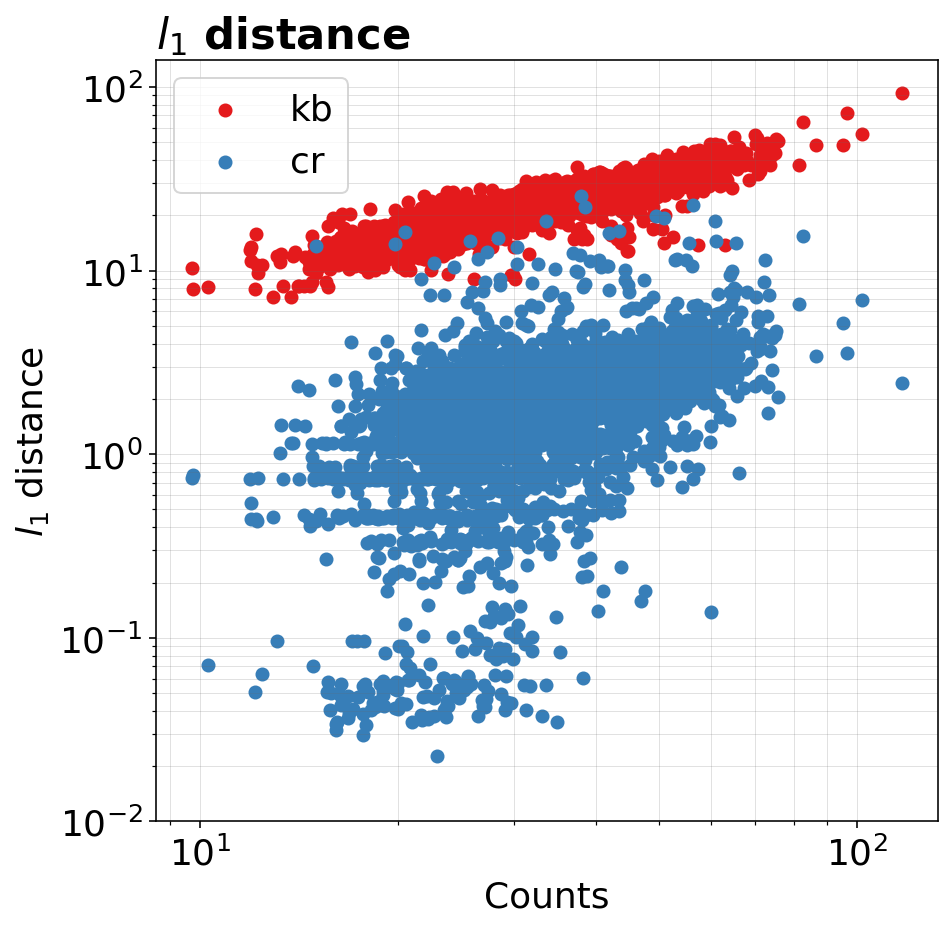

In [32]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)
ax.set(**{"ylim": 0.01})

fig.show()